# **Spark HW2 Moive Recommendation**
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

Recommender systems can be loosely broken down into three categories: content based systems, collaborative filtering systems, and hybrid systems (which use a combination of the other two)




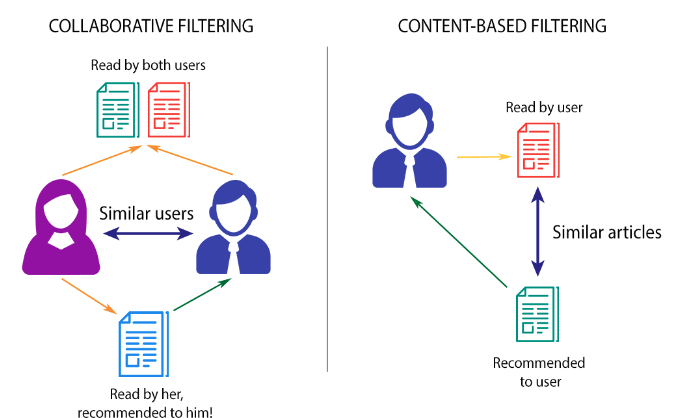


- Content based approach utilizes a series of discrete characteristics of an item in order to recommend additional items with similar properties. 

- Collaborative filtering approach builds a model from a user’s past behaviors (items previously purchased or selected and/or numerical ratings given to those items) as well as similar decisions made by other users. This model is then used to predict items (or ratings for items) that the user may have an interest in. (**)

- Hybrid approach combines the previous two approaches. Most businesses probably use hybrid approach in their production recommender systems.

# Set Up Environments

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
# import os
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part1: Collaborative Recommender

## Datasets

In [ ]:
cd /content/drive/MyDrive/Laioffer/csv_files/RecSys_Movie/

/content/drive/MyDrive/Laioffer/csv_files/RecSys_Movie


In [ ]:
ls

links.csv   ratings.csv  spark-3.2.1-bin-hadoop3.2/     tags.csv
movies.csv  README.txt   spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

In [ ]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Drop columns
df_movies = df_movies.drop(['genres'], axis=1)
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
dtypes: int64(1), object(1)
memory usage: 152.3+ KB


In [ ]:
# Drop columns
df_ratings = df_ratings.drop(['timestamp'], axis=1)
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


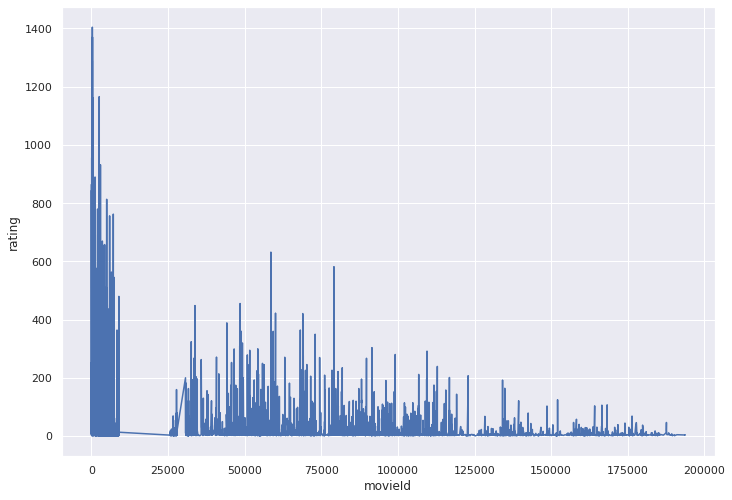

In [ ]:
df_ratings_groupby = df_ratings.groupby(['movieId']).sum()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=df_ratings_groupby, x="movieId", y="rating")

- In a real world setting, data collected from explicit feedbacks like movie ratings can be very sparse and data points are mostly collected from very popular items (movies) and highly engaged users. Large amount of less known items (movies) don’t have ratings at all. 

* These sparse ratings are less predictable for most users and highly sensitive to an individual person who loves the obscure movie, which makes the pattern very noisy.
* In general, most models make recommendations based on user rating patterns. To remove noisy pattern and avoid “memory error” due to large datasets, we will filter our dataframe of ratings to only popular movies. 

## Modeling

* Collaborative filtering systems use the actions of users to recommend other movies. In general, they can either be user-based or item-based. Item based approach is usually preferred over user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don’t change much, and item based approach often can be computed offline and served without constantly re-training.

* To implement an item based collaborative filtering, KNN is a perfect go-to model and also a very good baseline for recpmmendation system development.

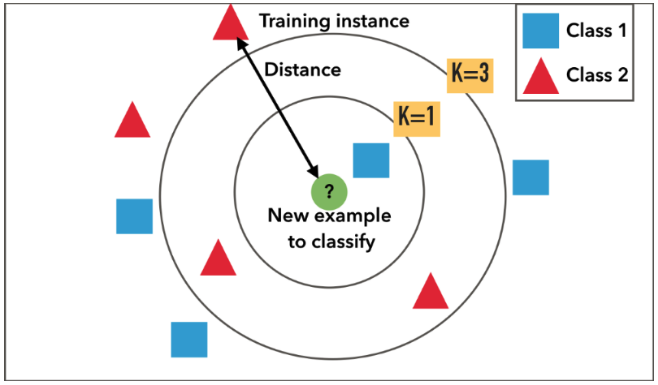

* KNN relies on item feature similarity. When KNN makes inference about a movie, KNN will calculate the “distance” between the target movie and every other movie in its database, then it ranks its distances and returns the top K nearest neighbor movies as the most similar movie recommendations.

- we need to transform the dataframe of ratings into a proper format that can be consumed by a KNN model. We want the data to be in an m x n array, where m is the number of movies and n is the number of users. To reshape dataframe of ratings, we’ll pivot the dataframe to the wide format with movies as rows and users as columns. 

In [ ]:
# pivot ratings into movie features
df_movie_features = df_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)  # fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors). 

df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from scipy.sparse import csr_matrix # used for an extremely sparse matrix 

# convert dataframe of movie features to scipy sparse matrix
mat_movie_features = csr_matrix(df_movie_features.values)

- Now our training data has a very high dimensionality. KNN’s performance will suffer from curse of dimensionality if it uses “euclidean distance” in its objective function. Euclidean distance is unhelpful in high dimensions because all vectors are almost equidistant to the search query vector (target movie’s features). 
- Instead, we will use cosine similarity for nearest neighbor search. This is a popular approach to handle nearest neighbor search in high dimensional data.


In [ ]:
# Configure the KNN model with proper hyper-params:

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
# def make_recommendations(self, fav_movie, n_recommendations):
#     """
#     make top n movie recommendations
#     Parameters
#     ----------
#     fav_movie: str, name of user input movie
#     n_recommendations: int, top n recommendations
#     """
#     # get data
#     movie_user_mat_sparse, hashmap = self._prep_data()
#     # get recommendations
#     raw_recommends = self._inference(
#         self.model, movie_user_mat_sparse, hashmap,
#         fav_movie, n_recommendations)
#     # print results
#     reverse_hashmap = {v: k for k, v in hashmap.items()}
#     print('Recommendations for {}:'.format(fav_movie))
#     for i, (idx, dist) in enumerate(raw_recommends):
#         print('{0}: {1}, with distance '
#               'of {2}'.format(i+1, reverse_hashmap[idx], dist))


- https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/src/knn_recommender.py

Using KNN recommend 

缺点：

1.  Popularity bias: recommender is prone to recommender popular items (People who watched “Iron Man” at that time probably also watched some of the recommended movies. This list of movies are not only popular during the same era but also share very similar genres and topics);

2. Item cold-start problem: recommender fails to recommend new or less-known items because items have either none or very little interactions (Recommending movies with diverse topics allow users to explore different tastes and keeps user engaged with the recommender product. On the other hand, lack of diversity will make users get bored and less engaged with the product.)

3. scalability issue: refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database